<h1>Table des matières<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1er-essai-:-k-means-+-rfm" data-toc-modified-id="1er-essai-:-k-means-+-rfm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1er essai : k-means + rfm</a></span><ul class="toc-item"><li><span><a href="#Choisir-le-nombre-approprié-de-clusters" data-toc-modified-id="Choisir-le-nombre-approprié-de-clusters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Choisir le nombre approprié de clusters</a></span></li><li><span><a href="#Vérification-de-la-cohérence-des-silhouettes-avec-un-undersampling" data-toc-modified-id="Vérification-de-la-cohérence-des-silhouettes-avec-un-undersampling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Vérification de la cohérence des silhouettes avec un undersampling</a></span></li><li><span><a href="#Reprise" data-toc-modified-id="Reprise-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Reprise</a></span></li></ul></li><li><span><a href="#Test-avec-DBSCAN" data-toc-modified-id="Test-avec-DBSCAN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test avec DBSCAN</a></span></li><li><span><a href="#Test-avec-AgglomerativeClustering" data-toc-modified-id="Test-avec-AgglomerativeClustering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test avec AgglomerativeClustering</a></span><ul class="toc-item"><li><span><a href="#Test-avec-KMeans-+-RF" data-toc-modified-id="Test-avec-KMeans-+-RF-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test avec KMeans + RF</a></span></li></ul></li><li><span><a href="#Bac-à-sable" data-toc-modified-id="Bac-à-sable-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bac à sable</a></span></li></ul></div>

**TODO : Faire un gros coup de propre et ajouter du texte**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from kneed import KneeLocator

from olist import *

from sklearn import decomposition
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.features.pcoords import parallel_coordinates

%matplotlib inline

## 1er essai : k-means + rfm

In [2]:
df_segmented_customers = pd.read_csv(
    'data/cleaned/olist_segmented_customers.csv'
)  # .sample(20000, random_state=42)

In [3]:
df_segmented_customers.drop('Unnamed: 0', axis=1, inplace=True)
df_segmented_customers.head()

,customer_unique_id,recency,days_since_first_order,frequency,total_payment,avg_payment,segment,sub_segment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,color
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,actif,actif_élevé,14409,-20.500253,-47.400367,red
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,actif,actif_faible,9790,-23.724844,-46.549350,deeppink
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactif,inactif,1151,-23.531294,-46.656404,midnightblue
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,chaud,chaud_faible,8775,-23.493944,-46.180817,darkorchid
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,chaud,chaud_élevé,13056,-22.993053,-47.139272,magenta


In [4]:
df_rfm = df_segmented_customers[['recency', 'frequency', 'total_payment']]

In [100]:
df_rfm_wt_f = df_segmented_customers[['recency', 'total_payment']]

In [5]:
df_rfm_sample = df_segmented_customers[[
    'recency', 'frequency', 'total_payment'
]].sample(10000, random_state=2)

In [98]:
df_rfm_sample_wt_f = df_segmented_customers[[
    'recency', 'total_payment'
]].sample(10000, random_state=2)

In [102]:
scaler = RobustScaler(quantile_range=(1, 99))

scaled_features = scaler.fit_transform(df_rfm)
scaled_features_wt_f = scaler.fit_transform(df_rfm_wt_f)

scaled_samples = scaler.fit_transform(df_rfm_sample)
scaled_samples_wt_f = scaler.fit_transform(df_rfm_sample_wt_f)

In [7]:
scaled_features[:5]

array([[-0.18904594,  0.        ,  0.04045358],
       [-0.18374558,  0.        , -0.07133002],
       [ 0.56360424,  0.        , -0.02087634],
       [ 0.1819788 ,  0.        , -0.06418997],
       [ 0.12367491,  0.        ,  0.09090726]])

In [8]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}

kmeans = KMeans(n_clusters=3, **kmeans_kwargs)

In [9]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=2)

In [10]:
# La valeur SSE la plus faible
kmeans.inertia_

7206.853118587315

In [11]:
# Emplacements finaux du centroïde
kmeans.cluster_centers_

array([[-1.59545509e-01, -6.38378239e-16,  4.70031753e-02],
       [ 3.44733824e-03,  1.11150695e+00,  1.87647522e-01],
       [ 2.98592947e-01, -6.38378239e-16,  4.94891128e-02]])

In [12]:
# Le nombre d'itérations nécessaires pour converger
kmeans.n_iter_

36

In [13]:
kmeans.labels_[:5]

array([0, 0, 2, 2, 2])

### Choisir le nombre approprié de clusters

In [14]:
# Une liste contient les valeurs SSE pour chaque k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

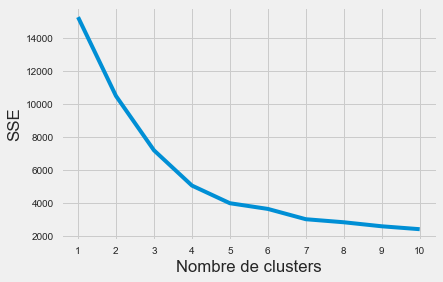

In [15]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Nombre de clusters")
plt.ylabel("SSE")
plt.show()

In [16]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

4

Essai avec Yellowbrick

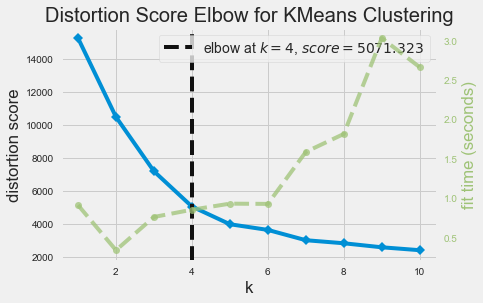

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model = KMeans(**kmeans_kwargs)
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(scaled_features)
visualizer.show()

In [18]:
# Une liste contient les coefficients de silhouette pour chaque k
silhouette_coefficients = []

# Notez que vous commencez à 2 clusters pour le coefficient de silhouette.
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

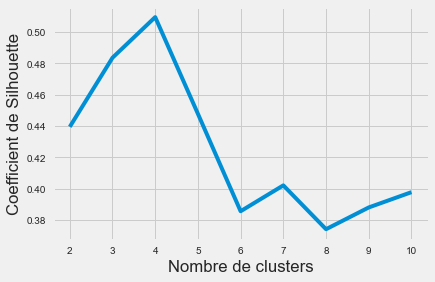

In [19]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Nombre de clusters")
plt.ylabel("Coefficient de Silhouette")
plt.show()

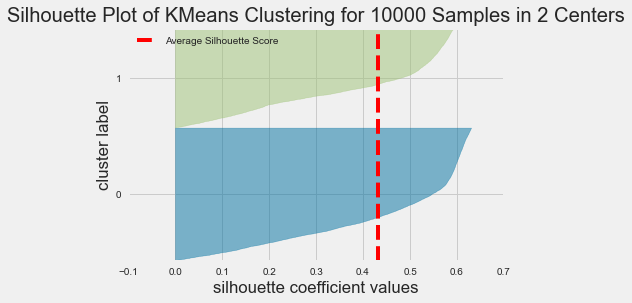

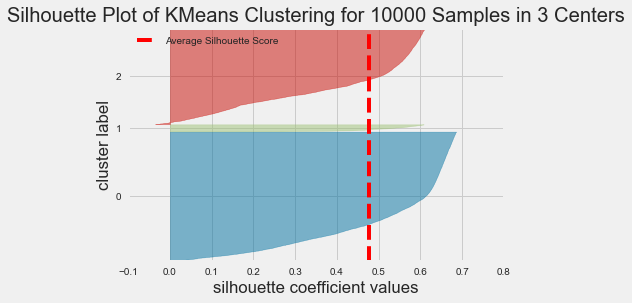

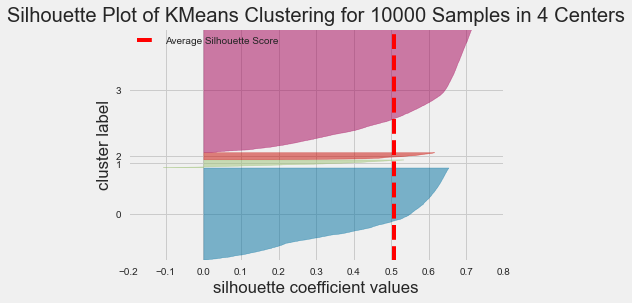

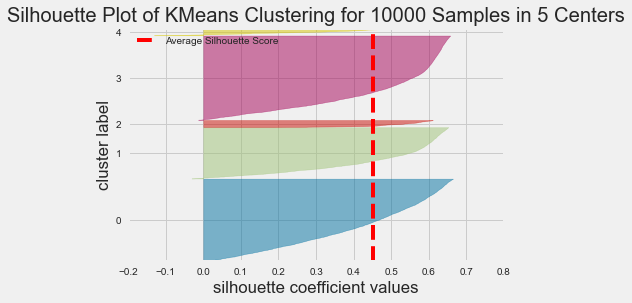

In [20]:
from yellowbrick.cluster import intercluster_distance
# Instanciation du modèle de clustering et du visualiseur

for n_cluster in range(2, 6):
    model = KMeans(n_cluster, **kmeans_kwargs)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(scaled_samples)  # Adapter les données au visualiseur
    visualizer.show()  # afficher la silhouette

### Vérification de la cohérence des silhouettes avec un undersampling

In [112]:
kmeans = KMeans(4, **kmeans_kwargs)
kmeans_check = kmeans.fit(scaled_samples)
kmeans_check_labels = kmeans_check.labels_
kmeans_check_rfm = df_rfm_sample.assign(Cluster=kmeans_check_labels)

Text(0.5, 1.0, 'Taille des clusters')

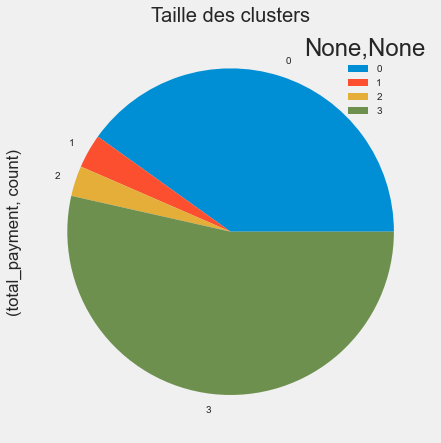

In [113]:
kmeans_check_group = kmeans_check_rfm.groupby('Cluster')

plt.figure(figsize=(10, 7))

kmeans_check_group.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
}).round(1)['total_payment', 'count'].plot(kind='pie', legend=True)

plt.title('Taille des clusters')

In [114]:
nb_samples = [sum(kmeans_check.labels_ == j) for j in range(4)]
nb_samples

[4011, 336, 301, 5352]

In [116]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

In [129]:
kmeans_check_rfm_under = downsample(kmeans_check_rfm, 'Cluster')

Text(0.5, 1.0, 'Taille des clusters')

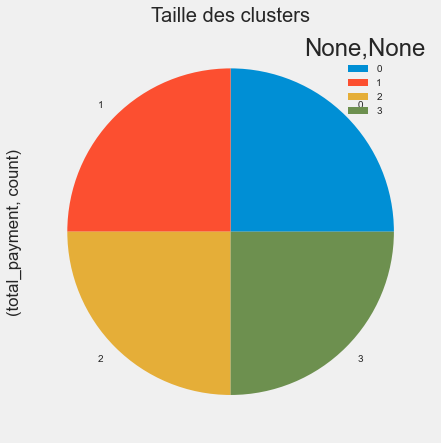

In [130]:
kmeans_check_group = kmeans_check_rfm_under.groupby('Cluster')

plt.figure(figsize=(10, 7))

kmeans_check_group.agg({
    'total_payment': ['count']
}).round(1)['total_payment', 'count'].plot(kind='pie', legend=True)

plt.title('Taille des clusters')

In [131]:
kmeans_check_rfm_under = kmeans_check_rfm_under.drop(columns='Cluster')

In [133]:
scaled_under = scaler.fit_transform(kmeans_check_rfm_under)

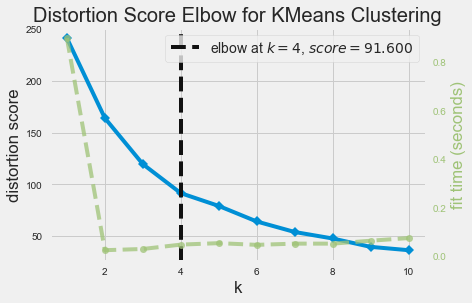

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [135]:
model = KMeans(**kmeans_kwargs)
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(scaled_under)
visualizer.show()

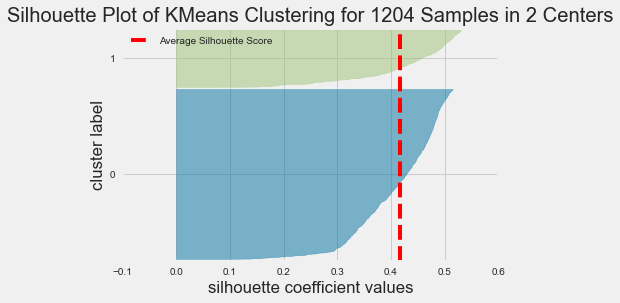

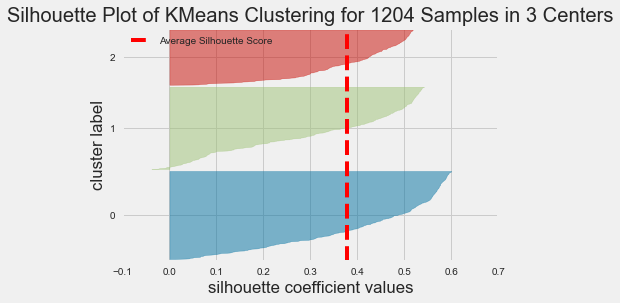

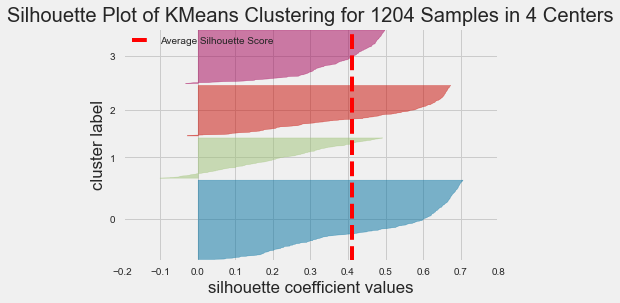

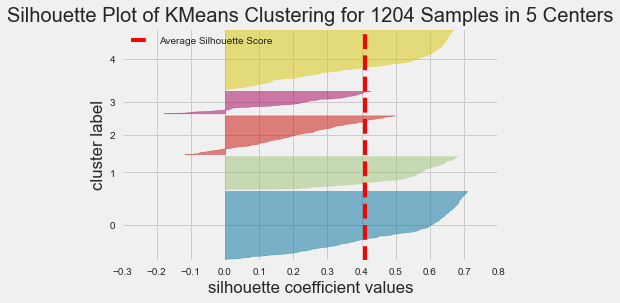

In [136]:
for n_cluster in range(2, 6):
    model = KMeans(n_cluster, **kmeans_kwargs)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(scaled_under)  # Adapter les données au visualiseur
    visualizer.show()  # afficher la silhouette

Le clustering a pris 0s


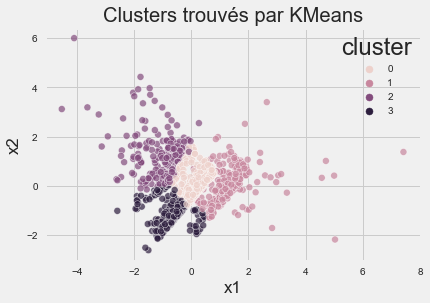

In [137]:
pca_clusters(scaled_under, cluster.KMeans, (), {'n_clusters':4})

### Reprise

In [21]:
davies_index = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, **kmeans_kwargs)
    model.fit(scaled_features)
    labels = model.labels_
    davies_index.append(davies_bouldin_score(df_rfm, labels))

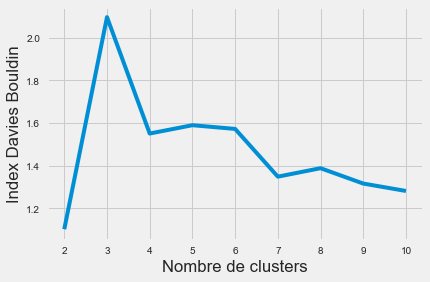

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), davies_index)
plt.xticks(range(2, 11))
plt.xlabel("Nombre de clusters")
plt.ylabel("Index Davies Bouldin")
plt.show()

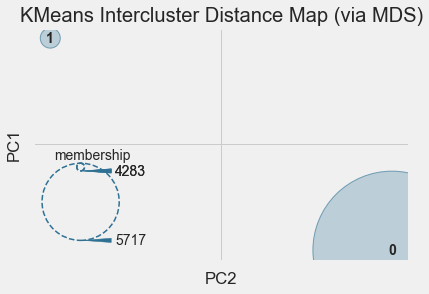

c:\python39\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



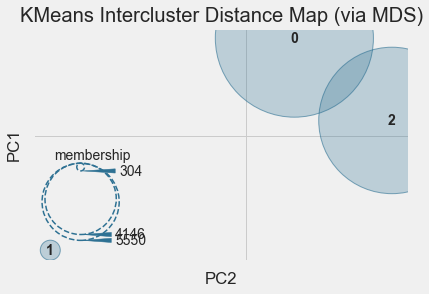

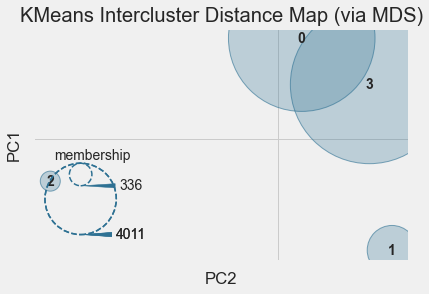

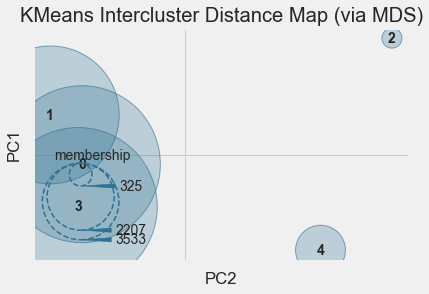

In [23]:
from yellowbrick.cluster import intercluster_distance
# Instanciation du modèle de clustering et du visualiseur

for n_cluster in range(2, 6):
    model = KMeans(n_cluster, **kmeans_kwargs)
    intercluster_distance(model, scaled_samples)

In [66]:
pca = decomposition.PCA(n_components=3).fit(scaled_features)
pca.explained_variance_ratio_.cumsum()

array([0.44465869, 0.75356728, 1.        ])

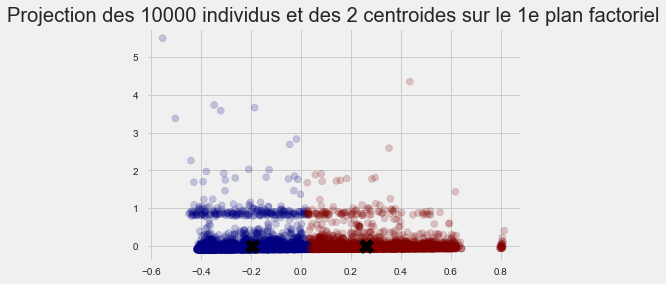

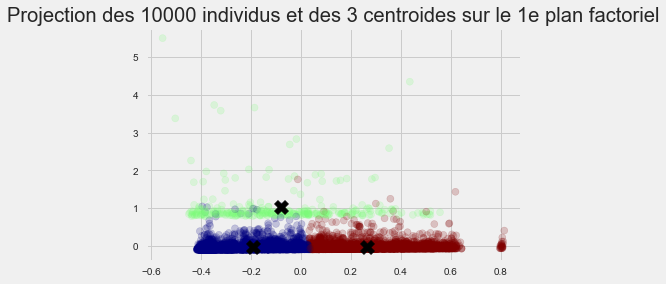

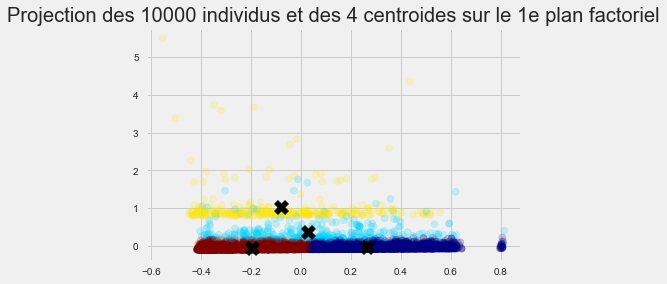

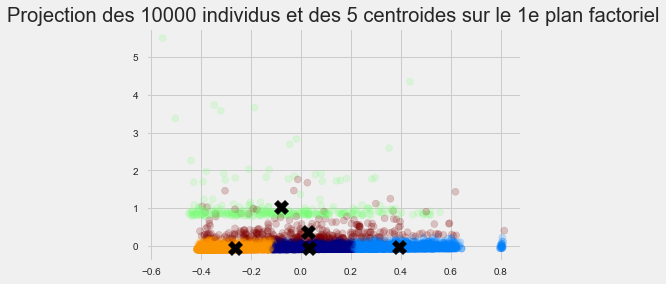

In [24]:
for n_cluster in range(2, 6):
    model = KMeans(n_cluster, **kmeans_kwargs)

    model.fit(scaled_samples)

    plt.figure()
    clusters = model.labels_

    pca = decomposition.PCA(n_components=2).fit(scaled_samples)
    X_projected = pca.transform(scaled_samples)

    centroids = model.cluster_centers_
    centroids_projected = pca.transform(centroids)

    plt.scatter(X_projected[:, 0],
                X_projected[:, 1],
                c=clusters.astype(float),
                cmap='jet',
                alpha=.2)
    plt.scatter(centroids_projected[:, 0],
                centroids_projected[:, 1],
                marker='X',
                color='black',
                alpha=1,
                s=200)

    plt.title(
        f"Projection des {X_projected.shape[0]} individus et des {n_cluster} centroides sur le 1e plan factoriel"
    )
    plt.show()

Text(0.5, 1.0, '3 clusters')

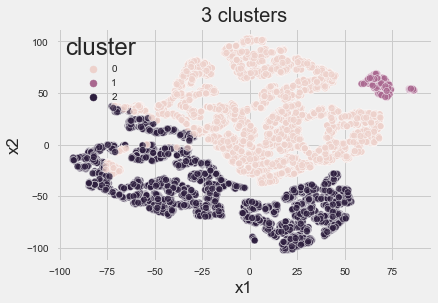

In [25]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
clustering_ori = kmeans.fit_predict(scaled_samples)
Xtsne = TSNE(n_components=2).fit_transform(scaled_samples)
tsne_rfm = pd.DataFrame(Xtsne)
tsne_rfm['cluster'] = clustering_ori
tsne_rfm.columns = ['x1', 'x2', 'cluster']
sns.scatterplot(data=tsne_rfm,
                x='x1',
                y='x2',
                hue='cluster',
                legend="full",
                alpha=0.7).set_title(f'3 clusters')

Text(0.5, 1.0, '4 clusters')

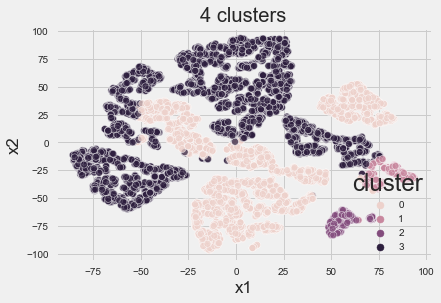

In [26]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
clustering_ori = kmeans.fit_predict(scaled_samples)
Xtsne = TSNE(n_components=2).fit_transform(scaled_samples)
tsne_rfm = pd.DataFrame(Xtsne)
tsne_rfm['cluster'] = clustering_ori
tsne_rfm.columns = ['x1', 'x2', 'cluster']
sns.scatterplot(data=tsne_rfm,
                x='x1',
                y='x2',
                hue='cluster',
                legend="full",
                alpha=0.7).set_title(f'4 clusters')

Text(0.5, 1.0, '4 clusters')

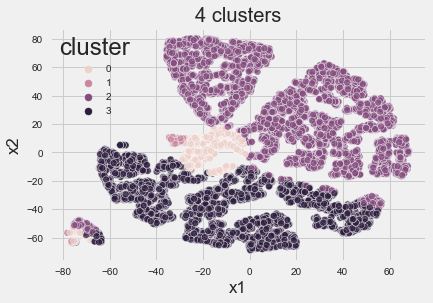

In [27]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
clustering_ori = kmeans.fit_predict(df_rfm_sample)
Xtsne = TSNE(n_components=2, n_jobs=4, perplexity=50,
             random_state=42).fit_transform(scaled_samples)
tsne_rfm = pd.DataFrame(Xtsne)
tsne_rfm['cluster'] = clustering_ori
tsne_rfm.columns = ['x1', 'x2', 'cluster']
sns.scatterplot(data=tsne_rfm,
                x='x1',
                y='x2',
                hue='cluster',
                legend="full",
                alpha=0.7).set_title(f'4 clusters')

Text(0.5, 1.0, '4 clusters')

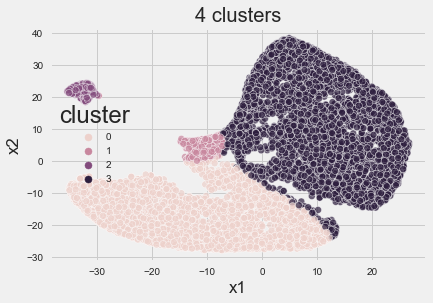

In [28]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
clustering_ori = kmeans.fit_predict(scaled_samples)
Xtsne = TSNE(n_components=2, n_jobs=4, perplexity=300,
             random_state=42).fit_transform(scaled_samples)
tsne_rfm = pd.DataFrame(Xtsne)
tsne_rfm['cluster'] = clustering_ori
tsne_rfm.columns = ['x1', 'x2', 'cluster']
sns.scatterplot(data=tsne_rfm,
                x='x1',
                y='x2',
                hue='cluster',
                legend="full",
                alpha=0.7).set_title(f'4 clusters')

Text(0.5, 1.0, '4 clusters')

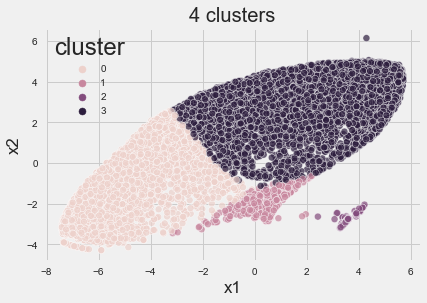

In [29]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
clustering_ori = kmeans.fit_predict(scaled_samples)
Xtsne = TSNE(n_components=2, n_jobs=4, perplexity=3000,
             random_state=42).fit_transform(scaled_samples)
tsne_rfm = pd.DataFrame(Xtsne)
tsne_rfm['cluster'] = clustering_ori
tsne_rfm.columns = ['x1', 'x2', 'cluster']
sns.scatterplot(data=tsne_rfm,
                x='x1',
                y='x2',
                hue='cluster',
                legend="full",
                alpha=0.7).set_title(f'4 clusters')

<AxesSubplot:>

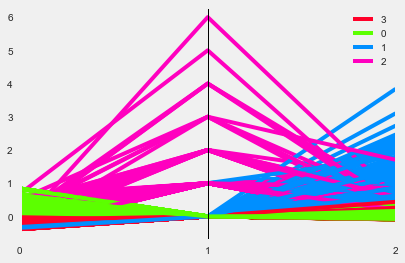

In [30]:
k_means = KMeans(n_clusters=4, random_state=1)
k_means.fit(scaled_samples)
pplot = kmeans.fit_predict(scaled_samples)
pplot_rfm = pd.DataFrame(scaled_samples)
pplot_rfm['cluster'] = pplot
pd.plotting.parallel_coordinates(pplot_rfm,
                                 'cluster',
                                 use_columns=True,
                                 colormap="gist_rainbow")

In [31]:
# no_outliers = np.empty((scaled_features.shape[0],scaled_features.shape[1]), int)

# for feature in range(0,scaled_features.shape[1]):
#     # 2. Déterminer la moyenne et l'écart-type
#     mean = np.mean(scaled_features[feature])
#     std_dev = np.std(scaled_features[feature])

#     # 3. Normaliser la matrice autour de 0
#     zero_based = abs(scaled_features[feature] - mean)

#     # 4. Définir le nombre maximum d'écarts types
#     max_deviations = 3

#     # 5. Accéder uniquement aux valeurs non aberrantes grâce à l'indexation booléenne
#     no_outliers[feature] = scaled_features[feature][zero_based < max_deviations * std_dev]

In [32]:
# for n_cluster in range(2,6):
#     model = KMeans(n_cluster, **kmeans_kwargs)

#     model.fit(no_outliers)

#     plt.figure()
#     clusters = model.labels_

#     pca = decomposition.PCA(n_components=2).fit(no_outliers)
#     X_projected = pca.transform(no_outliers)

#     centroids = model.cluster_centers_
#     centroids_projected = pca.transform(centroids)

#     plt.scatter(X_projected[:, 0], X_projected[:, 1],
#                 c=clusters.astype(np.float),
#                 cmap='jet', alpha=.2)
#     plt.scatter(centroids_projected[:,0],
#                 centroids_projected[:,1],
#                 marker='X',
#                 color='black',
#                 alpha=1,
#                 s=200)

#     plt.title(f"Projection des {X_projected.shape[0]} individus et des {n_cluster} centroides sur le 1e plan factoriel")
#     plt.show()

## Test avec DBSCAN

Le clustering a pris 1s


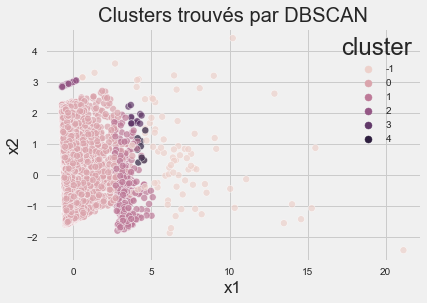

In [33]:
pca_clusters(df_rfm_sample, cluster.DBSCAN, (), {})

In [34]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

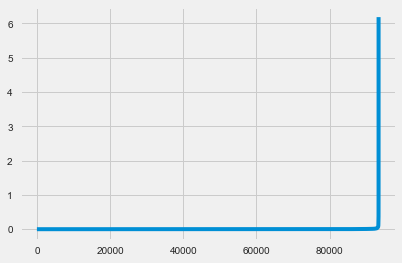

In [35]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

(93340.0, 93357.0)

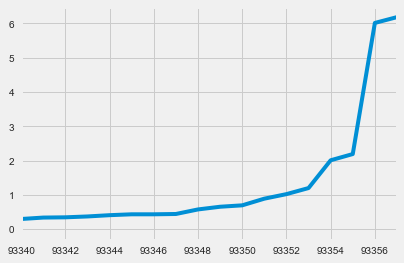

In [36]:
plt.plot(distances)
plt.xlim([93340, 93357])

Le clustering a pris 2s


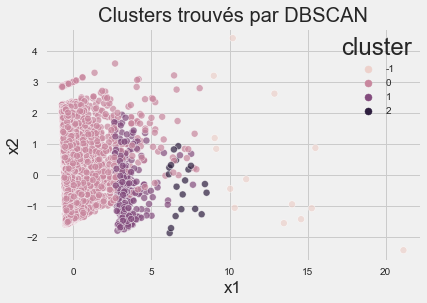

In [37]:
pca_clusters(df_rfm_sample, cluster.DBSCAN, (), {'eps':2, 'min_samples':6, 'n_jobs':4})

## Test avec AgglomerativeClustering

In [38]:
# La définition de distance_threshold=0 assure que nous calculons l'arbre au complet.
model_aggc = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_aggc = model_aggc.fit(scaled_samples)

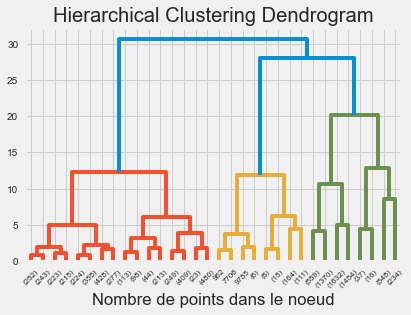

In [39]:
plt.title('Hierarchical Clustering Dendrogram')
# Trace les trois premiers niveaux du dendrogramme.
plot_dendrogram(model_aggc, truncate_mode='level', p=4)
plt.xlabel("Nombre de points dans le noeud")
plt.show()

Le clustering a pris 4s


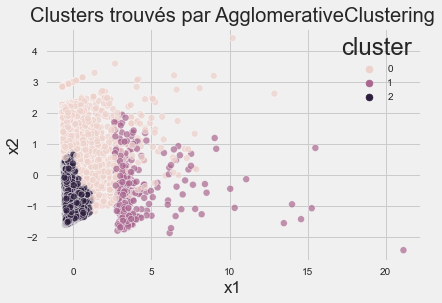

In [40]:
pca_clusters(df_rfm_sample, cluster.AgglomerativeClustering, (), {'n_clusters':3})

Le clustering a pris 4s


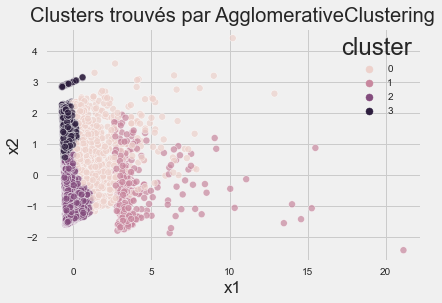

In [41]:
pca_clusters(df_rfm_sample, cluster.AgglomerativeClustering, (), {'n_clusters':4})

Le clustering a pris 4s


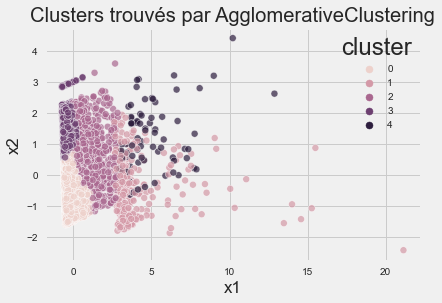

In [42]:
pca_clusters(df_rfm_sample, cluster.AgglomerativeClustering, (), {'n_clusters':5})

### Test avec KMeans + RF

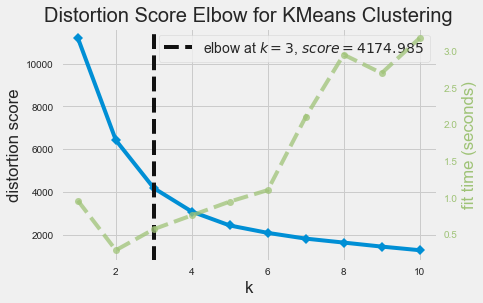

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
model = KMeans(**kmeans_kwargs)
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(scaled_features_wt_f)
visualizer.show()

In [104]:
# Une liste contient les coefficients de silhouette pour chaque k
silhouette_coefficients = []

# Notez que vous commencez à 2 clusters pour le coefficient de silhouette.
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features_wt_f)
    score = silhouette_score(scaled_features_wt_f, kmeans.labels_)
    silhouette_coefficients.append(score)

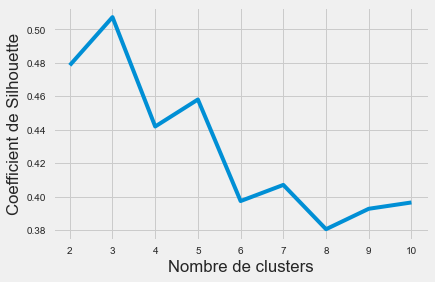

In [105]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Nombre de clusters")
plt.ylabel("Coefficient de Silhouette")
plt.show()

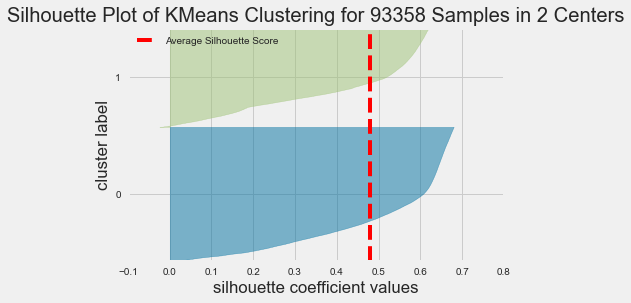

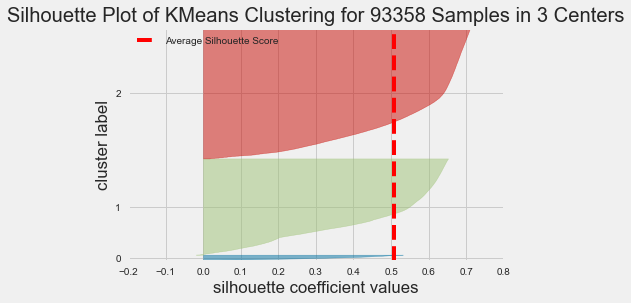

In [106]:
from yellowbrick.cluster import intercluster_distance
# Instanciation du modèle de clustering et du visualiseur

for n_cluster in range(2, 5):
    model = KMeans(n_cluster, **kmeans_kwargs)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(scaled_features_wt_f)  # Adapter les données au visualiseur
    visualizer.show()  # afficher la silhouette

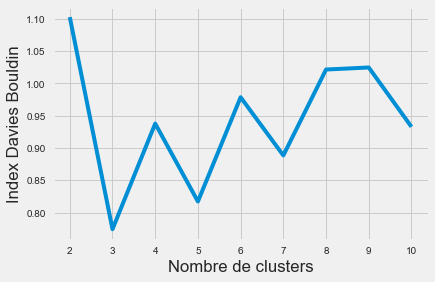

In [107]:
davies_index = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, **kmeans_kwargs)
    model.fit(scaled_features_wt_f)
    labels = model.labels_
    davies_index.append(davies_bouldin_score(df_rfm_wt_f, labels))

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), davies_index)
plt.xticks(range(2, 11))
plt.xlabel("Nombre de clusters")
plt.ylabel("Index Davies Bouldin")
plt.show()

Le clustering a pris 1s


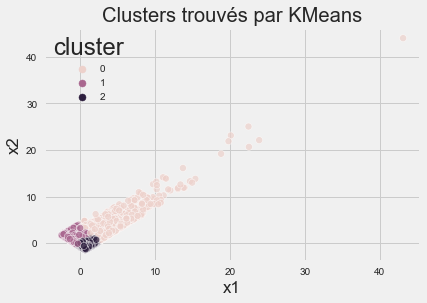

In [108]:
pca_clusters(df_rfm_wt_f, cluster.KMeans, (), {'n_clusters':3})

## Bac à sable

c:\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.



Le clustering a pris 74s


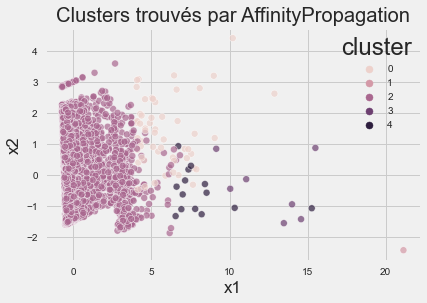

In [43]:
pca_clusters(df_rfm_sample, cluster.AffinityPropagation, (), {
    'preference': -5.0,
    'damping': 0.95
})

Le clustering a pris 0s


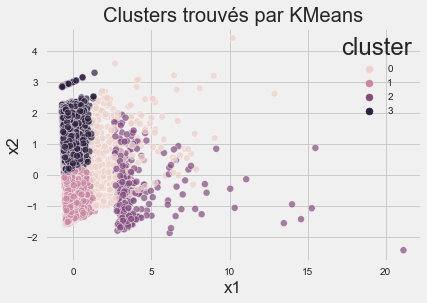

In [97]:
pca_clusters(df_rfm_sample, cluster.KMeans, (), {'n_clusters':4})

Le clustering a pris 0s


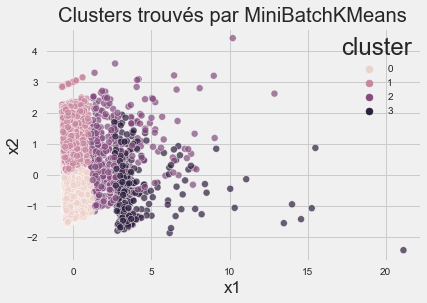

In [45]:
pca_clusters(df_rfm_sample, cluster.MiniBatchKMeans, (), {'n_clusters':4})

Le clustering a pris 0s


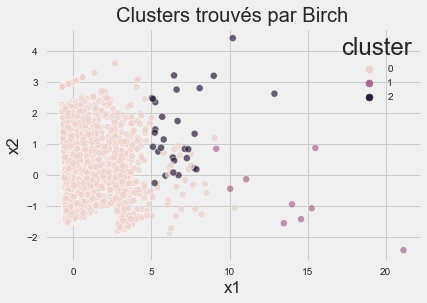

In [46]:
pca_clusters(df_rfm_sample, cluster.Birch, (), {})

Le clustering a pris 121s


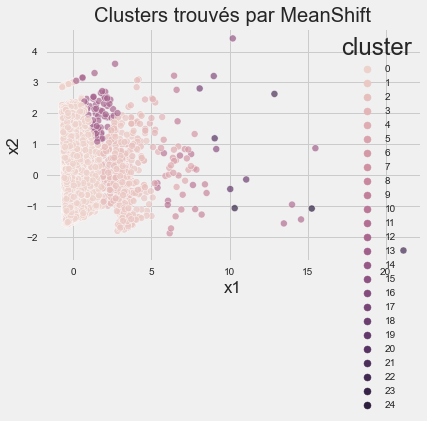

In [47]:
pca_clusters(df_rfm_sample, cluster.MeanShift, (), {})

Le clustering a pris 16s


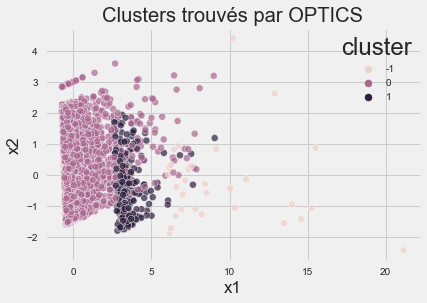

In [95]:
pca_clusters(df_rfm_sample, cluster.OPTICS, (), {'min_samples':50, 'xi':.05, 'min_cluster_size':.01})

Le clustering a pris 26s


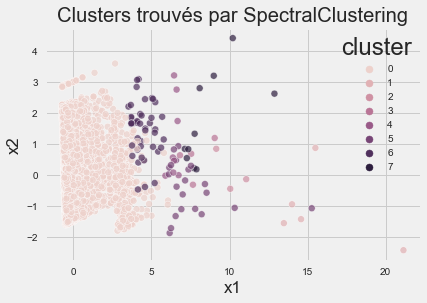

In [49]:
pca_clusters(df_rfm_sample, cluster.SpectralClustering, (), {})